In [1]:
%%capture
import sys
#sys.path.append("../../smt_modules")
sys.path.insert(0, "../../")
import glob, os
import pyicon as pyic
import smt_modules.all_funcs as eva
from smt_modules.icon_smt_levels import dzw, dzt, depthc, depthi
import smt_modules.tools as tools

import pandas as pd
import netCDF4 as nc
import xarray as xr    
from dask.diagnostics import ProgressBar
import numpy as np
import datetime          #https://docs.python.org/3/library/datetime.html

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d  #for converting cell to grid-centered coordinates
import cartopy.crs as ccrs
ccrs_proj = ccrs.PlateCarree()
import gsw

from scipy import stats    #Used for 2D binned statistics
from importlib import reload
import matplotlib.patches as patches
from matplotlib import colors

In [2]:
#Reload modules:
reload(eva)
reload(tools)

Load my smt functions


<module 'smt_modules.tools' from '/home/m/m300878/submesoscaletelescope/notebooks/october22/../../smt_modules/tools.py'>

#### calc hor velo

In [26]:
ds = eva.load_smt_vn()
ds

<xarray.DataArray 'vn001_sp' (depthc: 112, time: 984, ncells: 89813639)>
dask.array<concatenate, shape=(112, 984, 89813639), dtype=float32, chunksize=(1, 1, 89813639), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2010-01-09T01:00:00 ... 2010-03-31T23:00:00
  * depthc   (depthc) float64 2.5 6.5 9.5 12.5 ... 4.51e+03 4.975e+03 5.49e+03
Dimensions without coordinates: ncells
Attributes:
    standard_name:                vn at level 001
    code:                         255
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  3

In [32]:
pdtime = ds.time.isel(time=700)
print(f'{pdtime.data:.13}')

2010-03-08T09


In [18]:
int(itd0[0])

708

In [3]:
tgrid  = eva.load_smt_grid()
ds_IcD = pyic.convert_tgrid_data(tgrid)
ds_IcD = ds_IcD.compute()

In [5]:
edge2cell_coeff_cc = pyic.xr_calc_edge2cell_coeff_cc(ds_IcD)
edge2cell_coeff_cc = edge2cell_coeff_cc.compute()

In [6]:
edge_of_cell = ds_IcD.edge_of_cell.compute()

In [7]:
fixed_vol_norm = pyic.xr_calc_fixed_volume_norm(ds_IcD)
fixed_vol_norm = fixed_vol_norm.compute()

In [8]:
sinLon = np.sin(ds_IcD.clon*np.pi/180.)
cosLon = np.cos(ds_IcD.clon*np.pi/180.)
sinLat = np.sin(ds_IcD.clat*np.pi/180.)
cosLat = np.cos(ds_IcD.clat*np.pi/180.)

In [10]:
# old school

In [ ]:
p_vn_c = ( edge2cell_coeff_cc[:,:,:]
         * ve[edge_of_cell,np.newaxis]
         * dzw[lev]
         ).sum(axis=1)
p_vn_c *= 1./(fixed_vol_norm[:,np.newaxis]*dzw[lev])
u1 = p_vn_c[:,0]
u2 = p_vn_c[:,1]
u3 = p_vn_c[:,2]
uo =   u2*cosLon - u1*sinLon
vo = -(u1*cosLon + u2*sinLon)*sinLat + u3*cosLat

In [36]:
steps = np.arange(2)
steps

array([0, 1])

In [30]:
 pd_time = pd_time +  pd.DateOffset(hours=2)
 pd_time

Timestamp('2010-03-09 09:00:00')

In [14]:
ds.time.shape

(984,)

In [21]:
np.where(ds.time.values==pd_time)

AttributeError: 'tuple' object has no attribute 'type'

In [5]:
pd_time      = np.datetime64('2010-03-09T01:00:00')
ds.sel(time=pd_time)


<xarray.DataArray 'vn001_sp' (depthc: 112, ncells: 89813639)>
dask.array<getitem, shape=(112, 89813639), dtype=float32, chunksize=(1, 89813639), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 2010-03-09T01:00:00
  * depthc   (depthc) float64 2.5 6.5 9.5 12.5 ... 4.51e+03 4.975e+03 5.49e+03
Dimensions without coordinates: ncells
Attributes:
    standard_name:                vn at level 001
    code:                         255
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  3

In [37]:
ncells = ds_IcD.cell.size
ncells

59799625

In [11]:
step=100
vet = ds.isel(time=step)
ce = ds_IcD.edge.size

print("Calculate horizontal velocity")
for lev in np.arange(depthc.size):
    ve      = vet.isel(depthc=lev)
    ve      = ve.expand_dims(dim='depthc')
    ve      = ve.rename({'ncells': 'edge'})
    ve      = ve.compute() #important!
    dze     = xr.DataArray(dzw[lev]*np.ones((1,ce)), dims=['depthc', 'edge'])
    p_vn_c  = pyic.xr_edges2cell(ds_IcD, ve, dze, dzw[lev], edge2cell_coeff_cc=edge2cell_coeff_cc, fixed_vol_norm=fixed_vol_norm)
    u1 = p_vn_c[:,0]
    u2 = p_vn_c[:,1]
    u3 = p_vn_c[:,2]
    uo =   u2*cosLon - u1*sinLon
    vo = -(u1*cosLon + u2*sinLon)*sinLat + u3*cosLat
    break
#       #save
#     nc_u[kk,:] = uo[:cc]
#     nc_v[kk,:] = vo[:cc]
#     break

# fo.close()

print('finish calculate at')

Calculate horizontal velocity
finish calculate at


## visualize

In [12]:
dds = xr.open_dataset('/work/mh0033/m300878/smt/v/pp_calc_v_h2010-03-13T15.nc')

FileNotFoundError: [Errno 2] No such file or directory: b'/work/mh0033/m300878/smt/v/pp_calc_v_h2010-03-13T15.nc'

In [8]:
dds

<xarray.Dataset>
Dimensions:  (depthc: 112, ncells: 59799625)
Coordinates:
  * depthc   (depthc) float32 2.5 6.5 9.5 12.5 ... 4.51e+03 4.975e+03 5.49e+03
Dimensions without coordinates: ncells
Data variables:
    u        (depthc, ncells) float32 ...
    v        (depthc, ncells) float32 ...

In [9]:
data= dds.isel(depthc=111).v

In [10]:
eva.load_smt_v()

<xarray.Dataset>
Dimensions:  (time: 165, depthc: 112, ncells: 59799625)
Coordinates:
  * depthc   (depthc) float32 2.5 6.5 9.5 12.5 ... 4.51e+03 4.975e+03 5.49e+03
  * time     (time) datetime64[ns] 2010-03-09T01:00:00 ... 2010-03-22T17:00:00
    clon     (ncells) float64 -0.9462 -0.9462 -0.9463 ... -1.253 -1.253 -1.253
    clat     (ncells) float64 0.6369 0.637 0.6369 0.6369 ... 0.1647 0.1649 0.165
Dimensions without coordinates: ncells
Data variables:
    u        (time, depthc, ncells) float32 dask.array<chunksize=(1, 1, 59799625), meta=np.ndarray>
    v        (time, depthc, ncells) float32 dask.array<chunksize=(1, 1, 59799625), meta=np.ndarray>

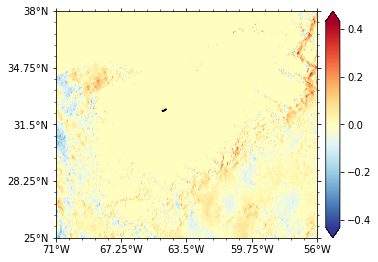

In [11]:
eva.plot_quick(data)

In [12]:
lon_reg = -71,-56
lat_reg = 25,38
fpath_ckdtree = '/work/mh0033/m300602/icon/grids/smt/ckdtree/rectgrids/smt_res0.02_180W-180E_90S-90N.nc'
uo = uo.rename({'cell': 'ncells'})
data  = pyic.interp_to_rectgrid_xr(uo, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)


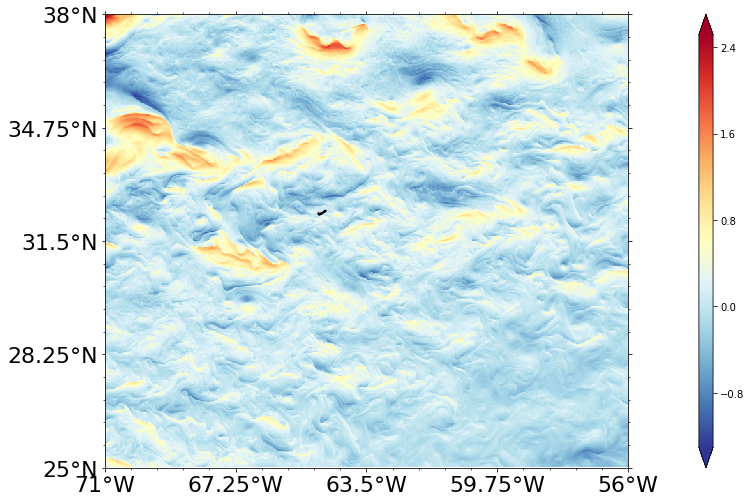

In [7]:
lon_reg = -71,-56
lat_reg = 25,38

asp = (lat_reg[1]-lat_reg[0])/(lon_reg[1]-lon_reg[0])
hca, hcb = pyic.arrange_axes(1, 1, plot_cb=True, asp=asp, fig_size_fac=4, projection=ccrs_proj, sharex=False, axlab_kw=None,  sharey=True, daxr=3)
ii=-1
ii+=1; ax=hca[ii]; cax=hcb[ii]

pyic.shade(data.lon, data.lat, data, ax=ax, cax=cax, transform=ccrs_proj, rasterized=False, cmap='RdYlBu_r')

for ax in hca:
    pyic.plot_settings(ax, xlim=lon_reg, ylim=lat_reg) 
    ax.tick_params(labelsize=22)


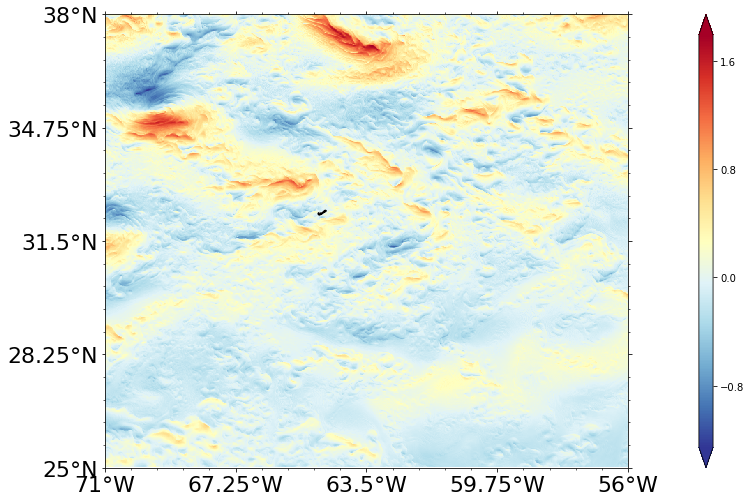

In [13]:

lon = ds_IcD.clon
lat = ds_IcD.clat
lon_reg = -71,-56
lat_reg = 25,38

asp = (lat_reg[1]-lat_reg[0])/(lon_reg[1]-lon_reg[0])
hca, hcb = pyic.arrange_axes(1, 1, plot_cb=True, asp=asp, fig_size_fac=4, projection=ccrs_proj, sharex=False, axlab_kw=None,  sharey=True, daxr=3)
ii=-1
ii+=1; ax=hca[ii]; cax=hcb[ii]

pyic.shade(data.lon, data.lat, data.isel(depthc=0), ax=ax, cax=cax, transform=ccrs_proj, rasterized=False, cmap='RdYlBu_r')

for ax in hca:
    pyic.plot_settings(ax, xlim=lon_reg, ylim=lat_reg) 
    ax.tick_params(labelsize=22)



In [14]:
p_vn_c_1 = p_vn_c

In [12]:
step=100
vet = ds.isel(time=step)
ce = ds_IcD.edge.size
lev=0

In [20]:
    ve      = vet.isel(depthc=lev)
    ve      = ve.expand_dims(dim='depth')
    ve      = ve.rename({'ncells': 'edge'})
    dze     = xr.DataArray(dzw[lev]*np.ones((1,ce)), dims=['depth', 'edge'])

In [69]:

def xr_edges2cell(ds_IcD, ve, dze, dzc, edge2cell_coeff_cc=None, fixed_vol_norm=None):
    if fixed_vol_norm is None:
        fixed_vol_norm = xr_calc_fixed_vol_norm(ds_IcD)
    if edge2cell_coeff_cc is None:
        edge2cell_coeff_cc = xr_calc_edge2cell_coeff_cc(ds_IcD)
    #if ve.dims != dze.dims:
    #  raise ValueError('::: Dims of ve and dze have to be the same!:::')
    p_vn_c = (
        edge2cell_coeff_cc 
        * ve.isel(edge=ds_IcD.edge_of_cell) 
        * dze
    ).sum(dim='nv')
    if 'depth' in p_vn_c.dims:
        p_vn_c = p_vn_c.transpose('depth', 'cell', 'cart')
    
    p_vn_c = p_vn_c / (
        fixed_vol_norm 
        * dzc
    )
    return p_vn_c


In [57]:
vet

<xarray.DataArray 'vn001_sp' (depthc: 112, ncells: 89813639)>
dask.array<getitem, shape=(112, 89813639), dtype=float32, chunksize=(1, 89813639), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 2010-01-17T09:00:00
  * depthc   (depthc) float64 2.5 6.5 9.5 12.5 ... 4.51e+03 4.975e+03 5.49e+03
Dimensions without coordinates: ncells
Attributes:
    standard_name:                vn at level 001
    code:                         255
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  3

In [60]:
step=100
vet = ds.isel(time=step)
ce = ds_IcD.edge.size

In [63]:



    ve      = vet
    #ve      = ve.expand_dims(dim='depthc')
    ve      = ve.rename({'ncells': 'edge'})
    #ve      = ve.compute() #important!
    dze     = xr.DataArray(dzw[lev]*np.ones((1,ce)), dims=['depthc', 'edge'])

In [65]:
dzw

array([  5. ,   3. ,   3. ,   3. ,   3. ,   3. ,   3. ,   3. ,   3. ,
         3. ,   3. ,   3. ,   3. ,   3. ,   3. ,   3. ,   3. ,   3. ,
         3. ,   3. ,   3. ,   3. ,   3. ,   3. ,   3. ,   3. ,   3. ,
         3. ,   3. ,   3. ,   3. ,   3. ,   3. ,   3. ,   3. ,   3. ,
         3. ,   3. ,   3. ,   3. ,   3. ,   3. ,   3. ,   3.5,   3.5,
         3.5,   3.5,   3.5,   3.5,   4. ,   4. ,   4. ,   4. ,   4. ,
         4.5,   4.5,   4.5,   4.5,   5. ,   5. ,   5.5,   6. ,   6.5,
         7. ,   7.5,   8. ,   8.5,  10. ,  11.5,  13. ,  14. ,  15. ,
        15.5,  16.5,  17. ,  18. ,  19. ,  20. ,  21. ,  22. ,  23. ,
        24. ,  26.5,  29.5,  32.5,  36. ,  40. ,  44.5,  49.5,  55. ,
        61. ,  67.5,  75. ,  83.5,  92.5, 102.5, 114. , 126.5, 140.5,
       156. , 173. , 192. , 213. , 236.5, 262.5, 291.5, 323.5, 359. ,
       398. , 441. , 488.5, 540.5])

In [70]:

    p_vn_c  = xr_edges2cell(ds_IcD, ve, dzw, dzw, edge2cell_coeff_cc=edge2cell_coeff_cc, fixed_vol_norm=fixed_vol_norm)
    u1 = p_vn_c[:,0]
    u2 = p_vn_c[:,1]
    u3 = p_vn_c[:,2]
    uo =   u2*cosLon - u1*sinLon
    vo = -(u1*cosLon + u2*sinLon)*sinLat + u3*cosLat


Exception ignored in: <generator object iter_fields at 0x7ffa3c73a0b0>
Traceback (most recent call last):
  File "/home/m/m300878/miniconda3/envs/pyicon_py39/lib/python3.9/ast.py", line 251, in iter_fields
    yield field, getattr(node, field)
KeyboardInterrupt: 

KeyboardInterrupt



In [72]:
edge2cell_coeff_cc

<xarray.DataArray (cell: 59799625, nv: 3, cart: 3)>
array([[[-3.58238497e-09,  8.80263150e-10,  3.79667694e-09],
        [-8.06738834e-10, -3.83092904e-09, -3.56311166e-09],
        [ 4.38836420e-09,  2.95049898e-09, -2.33669768e-10]],

       [[ 8.05658093e-10,  3.83029904e-09,  3.56257933e-09],
        [-4.38852023e-09, -2.95016100e-09,  2.33467914e-10],
        [-3.58106525e-09,  8.80049789e-10,  3.79505215e-09]],

       [[-4.38858588e-09, -2.95023186e-09,  2.33442098e-10],
        [ 3.58104768e-09, -8.80457477e-10, -3.79652878e-09],
        [-8.06545328e-10, -3.82941333e-09, -3.56195034e-09]],

       ...,

       [[ 2.58837155e-08,  8.45954175e-09, -2.29763575e-10],
        [-1.09937485e-08, -6.82066570e-10,  1.67440126e-08],
        [-8.28302194e-09, -6.89765935e-09, -2.38692646e-08]],

       [[-1.09926992e-08, -6.87800671e-10,  1.67092840e-08],
        [-8.25897156e-09, -6.89549763e-09, -2.38611014e-08],
        [ 2.58501200e-08,  8.45843951e-09, -2.17003201e-10]],

       [[-8.27376820e-09, -6.89725441e-09, -2.38433768e-08],
        [ 2.58523185e-08,  8.44835151e-09, -2.34784026e-10],
        [-1.09786642e-08, -6.76617223e-10,  1.67183682e-08]]])
Coordinates:
    elon     (cell, nv) float64 -54.21 -54.21 -54.21 ... -71.82 -71.82 -71.82
    elat     (cell, nv) float64 36.5 36.49 36.49 36.5 ... 9.447 9.458 9.453 9.45
    clon     (cell) float64 -54.21 -54.22 -54.22 -54.21 ... -71.82 -71.8 -71.82
    clat     (cell) float64 36.49 36.5 36.49 36.49 ... 9.447 9.437 9.447 9.453
Dimensions without coordinates: cell, nv, cart

In [75]:
%%time
    ve = ve.compute()

CPU times: user 2min 7s, sys: 1min 10s, total: 3min 18s
Wall time: 3min 30s


In [73]:
ve.isel(edge=ds_IcD.edge_of_cell)


KeyboardInterrupt



In [ ]:
p_vn_c = ( edge2cell_coeff_cc * ve.isel(edge=ds_IcD.edge_of_cell) * dze)

In [18]:
pd_time      = np.datetime64('2010-03-09')
tt = pd.date_range(start=pd_time, periods=100, freq='1D')

In [23]:
 nptest = dds.isel(depthc=0)

In [24]:
eva.smt

<xarray.Dataset>
Dimensions:  (ncells: 59799625)
Coordinates:
    depthc   float32 2.5
Dimensions without coordinates: ncells
Data variables:
    u        (ncells) float32 ...
    v        (ncells) float32 ...

In [21]:
765-712


53

In [22]:
53/6


8.833333333333334

In [23]:
8*6

48

In [24]:
256/6

42.666666666666664

In [25]:
12*4

48

In [34]:
v = eva.load_smt_v()
v

<xarray.Dataset>
Dimensions:  (time: 1, depthc: 112, ncells: 59799625)
Coordinates:
  * depthc   (depthc) float32 2.5 6.5 9.5 12.5 ... 4.51e+03 4.975e+03 5.49e+03
    clon     (ncells) float64 -0.9462 -0.9462 -0.9463 ... -1.253 -1.253 -1.253
    clat     (ncells) float64 0.6369 0.637 0.6369 0.6369 ... 0.1647 0.1649 0.165
Dimensions without coordinates: time, ncells
Data variables:
    u        (time, depthc, ncells) float32 dask.array<chunksize=(1, 1, 59799625), meta=np.ndarray>
    v        (time, depthc, ncells) float32 dask.array<chunksize=(1, 1, 59799625), meta=np.ndarray>

In [35]:
v.time

<xarray.DataArray 'time' (time: 1)>
array([0])
Dimensions without coordinates: time